<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:300%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="font-size:30px;text-align:center">Brain Tumor Detection using MRI images</p>
</div>


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/major-proj")

Mounted at /content/drive/


In [ ]:
!ls

brain_tumor_dataset  dataset-brain-tumor  model_plot.png
dataset		     model		  vgg19_final.h5


In [ ]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from tqdm import tqdm
import cv2
import imutils
np.random.seed(42)
tf.random.set_seed(42)
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
X,Y, labels = load_data('brain_tumor_dataset/', (224,224))

100%|██████████| 2/2 [00:27<00:00, 13.59s/it]

253 images loaded from brain_tumor_dataset/ directory.



<ipython-input-1-e1b30ccf3e1c>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

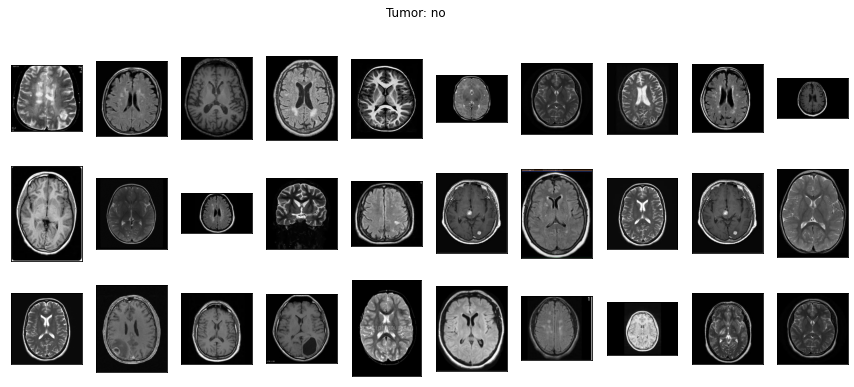

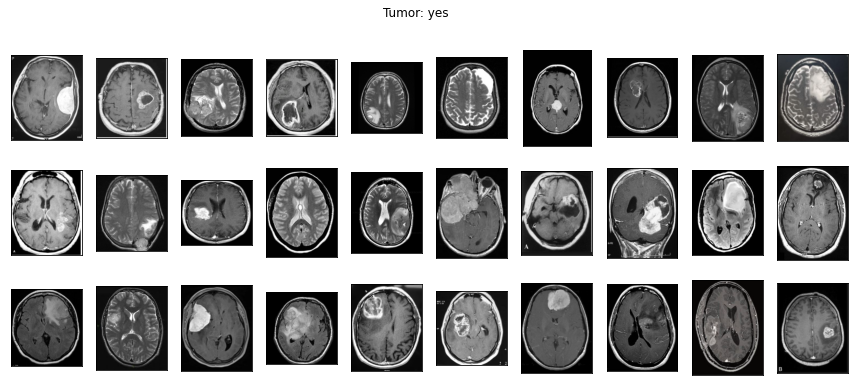

In [ ]:
plot_samples(X, Y, labels, 30)

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
X_crop = crop_imgs(set_name=X)

<ipython-input-11-65876982ba26>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(set_new)


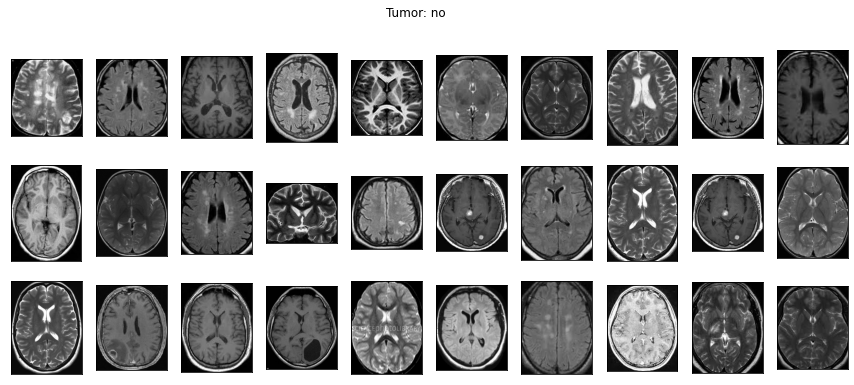

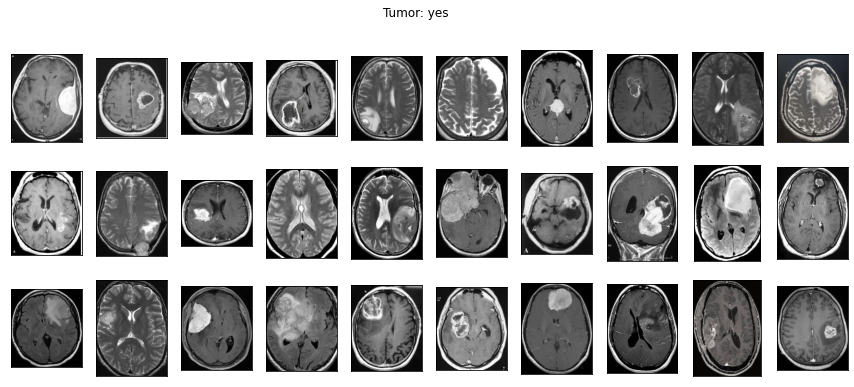

In [ ]:
plot_samples(X_crop, Y, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'no/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'yes/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# save_new_images(X_crop,Y, folder_name='dataset-brain-tumor/')

In [ ]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

In [ ]:
data_dir = 'brain_tumor_dataset/'

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


## 3. Image demonstration

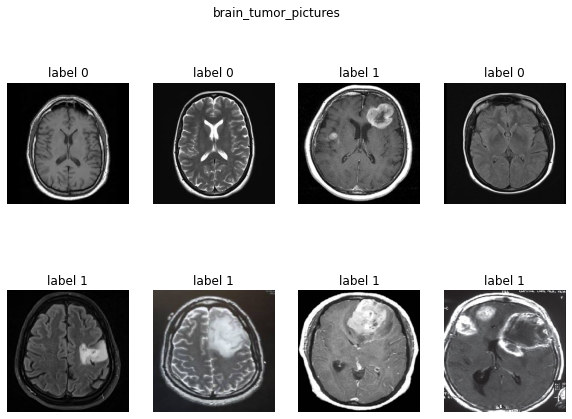

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

# CNN Implementation

## VGG19 


In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [early,checkpoint]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 4.4405 - acc: 0.6108 
Epoch 1: acc improved from -inf to 0.61084, saving model to model/vgg19_best.h5
4/4 [==============================] - 208s 51s/step - loss: 4.4405 - acc: 0.6108 - val_loss: 8.5784 - val_acc: 0.3800
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 5.3521 - acc: 0.5961 
Epoch 2: acc did not improve from 0.61084
4/4 [==============================] - 206s 50s/step - loss: 5.3521 - acc: 0.5961 - val_loss: 6.2209 - val_acc: 0.6400
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 3.2853 - acc: 0.7389 
Epoch 3: acc improved from 0.61084 to 0.73892, saving model to model/vgg19_best.h5
4/4 [==============================] - 202s 51s/step - loss: 3.2853 - acc: 0.7389 - val_loss: 4.2892 - val_acc: 0.6600
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 3.1068 - acc: 0.6552 
Epoch 4: acc did not improve from 0.73892
4/4 [==============================] - 210s 

In [ ]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 42s 42s/step - loss: 0.7342 - acc: 0.8200


,Train,Val
Loss,0.00135,0.734243
Acc,1.00000,0.820000


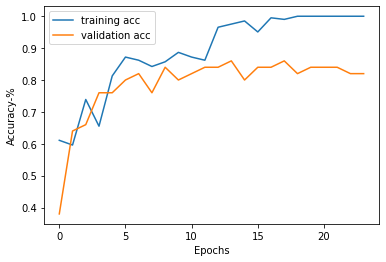

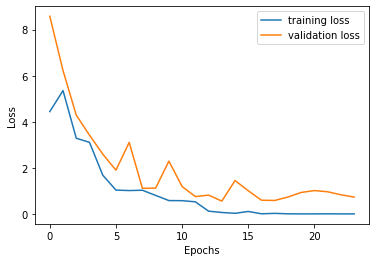

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

<h3>Adding Image Augmentation</h3>

In [ ]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 0.6140 - acc: 0.8379 
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 296s 80s/step - loss: 0.6140 - acc: 0.8379 - val_loss: 0.4739 - val_acc: 0.8800 - lr: 0.0100
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.5306 - acc: 0.8300 
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 267s 71s/step - loss: 0.5306 - acc: 0.8300 - val_loss: 0.3702 - val_acc: 0.8800 - lr: 0.0100
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.4727 - acc: 0.8696 
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 259s 68s/step - loss: 0.4727 - acc: 0.8696 - val_loss: 0.2987 - val_acc: 0.8800 - lr: 0.0100
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.2609 - acc: 0.9091 
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 248s 64s/step - loss: 0.2609 - acc: 0.9091 - 

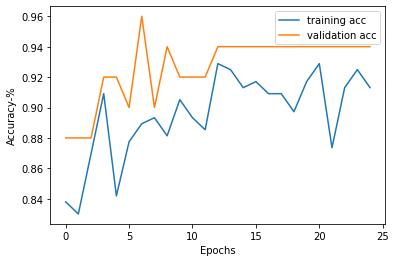

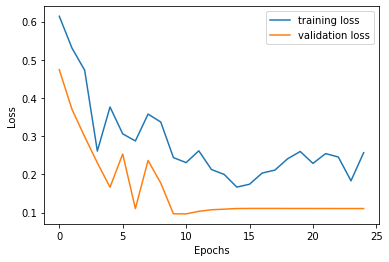

In [ ]:
plot_learning_curve(history)

## Final VGG19 model results

In [ ]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 38s 38s/step - loss: 0.1104 - acc: 0.9400


,Train,Val
Loss,0.003221,0.110449
Acc,1.000000,0.940000


In [ ]:
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

2/2 [==============================] - 41s 14s/step
[[16  3]
 [ 0 31]]

               precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.91      0.95        34

    accuracy                           0.94        50
   macro avg       0.92      0.96      0.93        50
weighted avg       0.95      0.94      0.94        50



In [ ]:
#save model
# model_vgg19.save('model/vgg19_saved.h5')

## InceptionV3


In [ ]:
# inception v3
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# train inception v3
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 4.1445 - acc: 0.6847
Epoch 1: acc improved from -inf to 0.68473, saving model to model/inceptionv3_best.h5
4/4 [==============================] - 78s 18s/step - loss: 4.1445 - acc: 0.6847 - val_loss: 2.4326 - val_acc: 0.5400
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.9487 - acc: 0.8227 
Epoch 2: acc improved from 0.68473 to 0.82266, saving model to model/inceptionv3_best.h5
4/4 [==============================] - 74s 24s/step - loss: 0.9487 - acc: 0.8227 - val_loss: 1.3193 - val_acc: 0.8600
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.4517 - acc: 0.9113 
Epoch 3: acc improved from 0.82266 to 0.91133, saving model to model/inceptionv3_best.h5
4/4 [==============================] - 69s 22s/step - loss: 0.4517 - acc: 0.9113 - val_loss: 1.1818 - val_acc: 0.8800
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.4445 - acc: 0.9212 
Epoch 4: acc improved from 0.91

In [ ]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 13s 13s/step - loss: 0.7666 - acc: 0.9200


,Train,Val
Loss,0.001981,0.766553
Acc,1.000000,0.920000


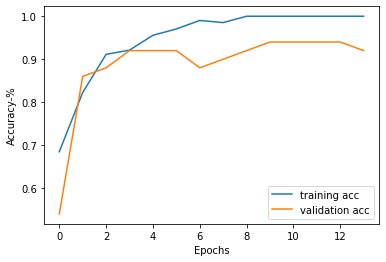

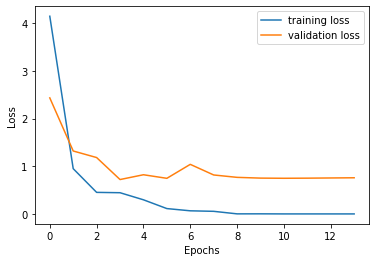

In [ ]:
plot_learning_curve(history)

<h3>Adding Image augmentation</h3>

In [ ]:
aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 1.5684 - acc: 0.7984 
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 94s 24s/step - loss: 1.5684 - acc: 0.7984 - val_loss: 1.2867 - val_acc: 0.8200 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.9144 - acc: 0.8617 
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 92s 24s/step - loss: 0.9144 - acc: 0.8617 - val_loss: 0.9078 - val_acc: 0.8600 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.4812 - acc: 0.8617 
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 84s 21s/step - loss: 0.4812 - acc: 0.8617 - val_loss: 0.0993 - val_acc: 0.9400 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.4470 - acc: 0.9209 
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 87s 22s

## Final InceptionV3 model results

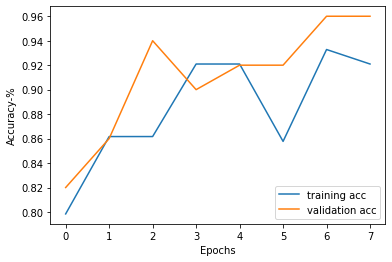

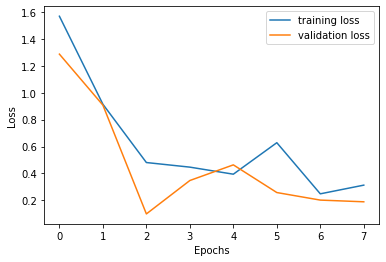

In [ ]:
plot_learning_curve(history)

In [ ]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 14s 14s/step - loss: 0.0993 - acc: 0.9400


,Train,Val
Loss,0.008302,0.099345
Acc,0.995074,0.940000


In [ ]:

ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

2/2 [==============================] - 15s 6s/step
Confusion_Matrix:
 [[16  3]
 [ 0 31]]

Classification_report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.91      0.95        34

    accuracy                           0.94        50
   macro avg       0.92      0.96      0.93        50
weighted avg       0.95      0.94      0.94        50



In [ ]:
# model_inceptionv3.save('model/incv3_saved.h5')

In [ ]:
model = tf.keras.models.load_model('vgg19_final.h5')

In [ ]:
IMGS = 224
img_size = (IMGS, IMGS)
model_builder = model
def preprocess_input(img):
    img_arr = cv2.imread(img)
#     img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    img_arr = cv2.resize(img_arr, img_size)
    img_arr = img_arr.reshape(IMGS, IMGS, 3)
    return img_arr

In [ ]:
lay = []
for layer in model.layers:
    lay.append(layer.name)
    print(layer.name)

input_17
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten_14
dense_13


In [ ]:
os.chdir("/content/drive/MyDrive/")

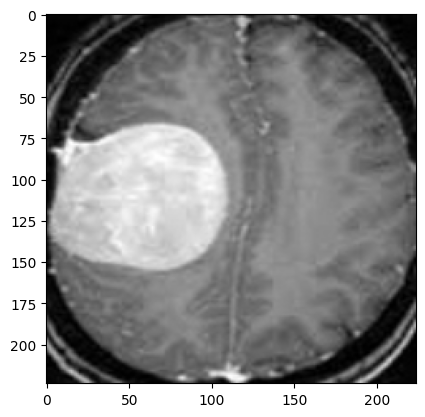

In [ ]:

last_conv_layer_name = lay[20]
classifier_layer_names = lay[21:]
img_path = 'Brain_tumor/TEST_CROP/YES/7.jpg'
plt.imshow(preprocess_input(img_path))
plt.show()

In [ ]:
def get_img_array(img_path, size):
    img_arr = cv2.imread(img_path)
#     img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    img_arr = cv2.resize(img_arr, (IMGS, IMGS))
    img_arr = img_arr.reshape(1, IMGS, IMGS, 3)
    return img_arr
#     return img_arr

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
last_conv_layer_name = lay[20]
img_size = (224,224)
img_path = '/content/drive/MyDrive/Brain_tumor/TEST_CROP/YES/7.jpg'
img_array = get_img_array(img_path, img_size)
model.layers[-1].activation = None
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

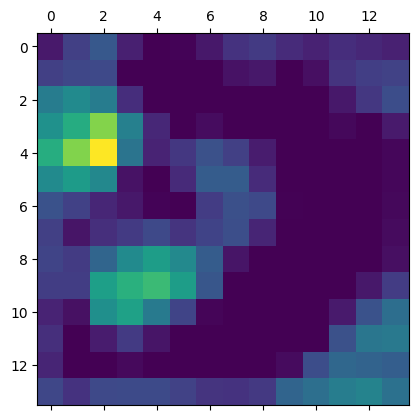

In [ ]:
plt.matshow(heatmap)
plt.show()

<ipython-input-14-6ef838873d8e>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


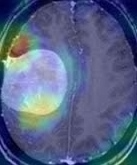

In [ ]:
import matplotlib.cm as cm #jet colors
from IPython.display import Image, display

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # Display Grad CAM
    display(superimposed_img)


save_and_display_gradcam(img_path, heatmap)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
def predict_tumor(img_path):
  img_width, img_height = 224, 224
  img = image.load_img(img_path, target_size = (img_width, img_height))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  pred = model.predict(img)[0][0]
  if(pred>0):
    print('TUMOR')
  else:
    print('NO TUMOR')
  save_and_display_gradcam(img_path, heatmap)

1/1 [==============================] - 1s 1s/step
TUMOR


<ipython-input-14-6ef838873d8e>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


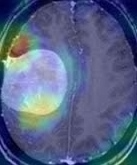

In [ ]:
img_path = '/content/drive/MyDrive/Brain_tumor/TEST_CROP/YES/7.jpg'
predict_tumor(img_path)